# Implementação Simples do Algoritmo K-Means

**Objetivo**: Implementar K-Means conforme especificação do exercício.

## Algoritmo:
```
Para cada época:
    for all x ∈ conjunto de dados do
        if x está mais próximo de r1 do que r2 then
            r1 ← (1 - α) × r1 + α × x
        else if x está mais próximo de r2 do que r1 then
            r2 ← (1 - α) × r2 + α × x
        end if
    end for
```


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# Carregar dados
df = pd.read_csv('dados_gaussianos.csv')
dados = df[['X', 'Y']].values
labels_verdadeiras = df['Label'].values
print(f"Dados carregados: {len(dados)} pontos")


Dados carregados: 1000 pontos


In [33]:
def kmeans_online(dados, alpha, n_epocas, seed=42):
    """K-Means com atualização após cada ponto."""
    np.random.seed(seed)
    
    # Escolher dois pontos aleatórios
    indices = np.random.choice(len(dados), size=2, replace=False)
    r1 = dados[indices[0]].copy()
    r2 = dados[indices[1]].copy()
    
    hist_atualizacoes = [(r1.copy(), r2.copy())]  # (i)
    hist_epocas = []  # (ii)
    
    for epoca in range(n_epocas):
        for x in dados:
            dist_r1 = np.linalg.norm(x - r1)
            dist_r2 = np.linalg.norm(x - r2)
            
            if dist_r1 < dist_r2:
                r1 = (1 - alpha) * r1 + alpha * x
                hist_atualizacoes.append((r1.copy(), r2.copy()))
            elif dist_r2 < dist_r1:
                r2 = (1 - alpha) * r2 + alpha * x
                hist_atualizacoes.append((r1.copy(), r2.copy()))
        
        hist_epocas.append((r1.copy(), r2.copy()))
    
    return hist_atualizacoes, hist_epocas, r1, r2


In [34]:
# Ponto 2: Executar com α = 10E-5, 10 épocas
alpha = 10e-5
n_epocas = 10

hist_atualizacoes, hist_epocas, r1_final, r2_final = kmeans_online(dados, alpha, n_epocas)

print(f"Representantes finais: r1 = {r1_final}, r2 = {r2_final}")
print(f"Atualizações: {len(hist_atualizacoes)}, Épocas: {len(hist_epocas)}")


Representantes finais: r1 = [1.04831857 1.03733155], r2 = [4.40840328 1.65229799]
Atualizações: 10001, Épocas: 10


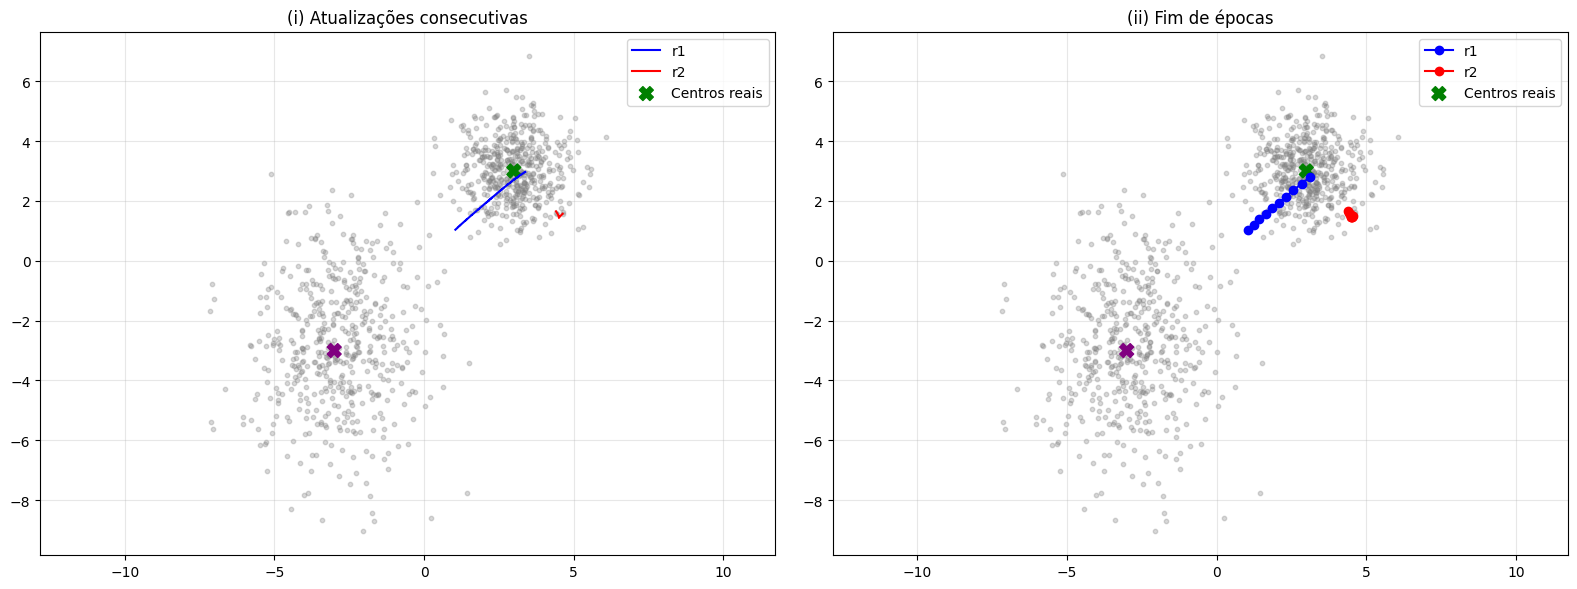

In [35]:
# Ponto 3: Visualizar (i) e (ii) em dois gráficos diferentes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extrair trajetórias
r1_traj_atualiz = np.array([r1 for r1, r2 in hist_atualizacoes])
r2_traj_atualiz = np.array([r2 for r1, r2 in hist_atualizacoes])
r1_traj_epocas = np.array([r1 for r1, r2 in hist_epocas])
r2_traj_epocas = np.array([r2 for r1, r2 in hist_epocas])

# Gráfico (i): Todas as atualizações consecutivas
axes[0].scatter(dados[:, 0], dados[:, 1], alpha=0.3, s=10, c='gray')
axes[0].plot(r1_traj_atualiz[:, 0], r1_traj_atualiz[:, 1], 'b-', label='r1')
axes[0].plot(r2_traj_atualiz[:, 0], r2_traj_atualiz[:, 1], 'r-', label='r2')
axes[0].scatter([3, -3], [3, -3], c=['green', 'purple'], s=100, marker='X', label='Centros reais')
axes[0].set_title('(i) Atualizações consecutivas')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Gráfico (ii): Fim de cada época
axes[1].scatter(dados[:, 0], dados[:, 1], alpha=0.3, s=10, c='gray')
axes[1].plot(r1_traj_epocas[:, 0], r1_traj_epocas[:, 1], 'b-o', label='r1')
axes[1].plot(r2_traj_epocas[:, 0], r2_traj_epocas[:, 1], 'r-o', label='r2')
axes[1].scatter([3, -3], [3, -3], c=['green', 'purple'], s=100, marker='X', label='Centros reais')
axes[1].set_title('(ii) Fim de épocas')
axes[1].legend()
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [36]:
# Ponto 3: Testar diferentes valores de α
alphas = [10e-5, 0.01, 0.1]

print("Comparação de diferentes α:")
for a in alphas:
    _, _, r1, r2 = kmeans_online(dados, a, 10)
    print(f"α={a:6.5f}: r1={r1}, r2={r2}")

print("\nConclusões:")
print("- α pequeno: convergência lenta mas estável")
print("- α grande: convergência rápida mas pode oscilar")
print("- Representantes tendem para os centros [3,3] e [-3,-3]")


Comparação de diferentes α:
α=0.00010: r1=[1.04831857 1.03733155], r2=[4.40840328 1.65229799]
α=0.01000: r1=[-2.99362103 -2.94188445], r2=[3.03414547 2.99516671]
α=0.10000: r1=[-2.87287345 -2.93957534], r2=[2.97662655 3.16429111]

Conclusões:
- α pequeno: convergência lenta mas estável
- α grande: convergência rápida mas pode oscilar
- Representantes tendem para os centros [3,3] e [-3,-3]


In [37]:
def kmeans_batch(dados, alpha, n_epocas, seed=42):
    """Ponto 4: K-Means batch - acumular alterações."""
    np.random.seed(seed)
    
    indices = np.random.choice(len(dados), size=2, replace=False)
    r1 = dados[indices[0]].copy()
    r2 = dados[indices[1]].copy()
    
    hist_epocas = [(r1.copy(), r2.copy())]
    
    for epoca in range(n_epocas):
        # Acumular alterações
        d1 = np.zeros(2)
        d2 = np.zeros(2)
        count1 = count2 = 0
        
        for x in dados:
            dist_r1 = np.linalg.norm(x - r1)
            dist_r2 = np.linalg.norm(x - r2)
            
            if dist_r1 < dist_r2:
                d1 += (x - r1)
                count1 += 1
            elif dist_r2 < dist_r1:
                d2 += (x - r2)
                count2 += 1
        
        # Aplicar alterações acumuladas
        if count1 > 0:
            r1 = r1 + (alpha / count1) * d1
        if count2 > 0:
            r2 = r2 + (alpha / count2) * d2
        
        hist_epocas.append((r1.copy(), r2.copy()))
    
    return hist_epocas, r1, r2


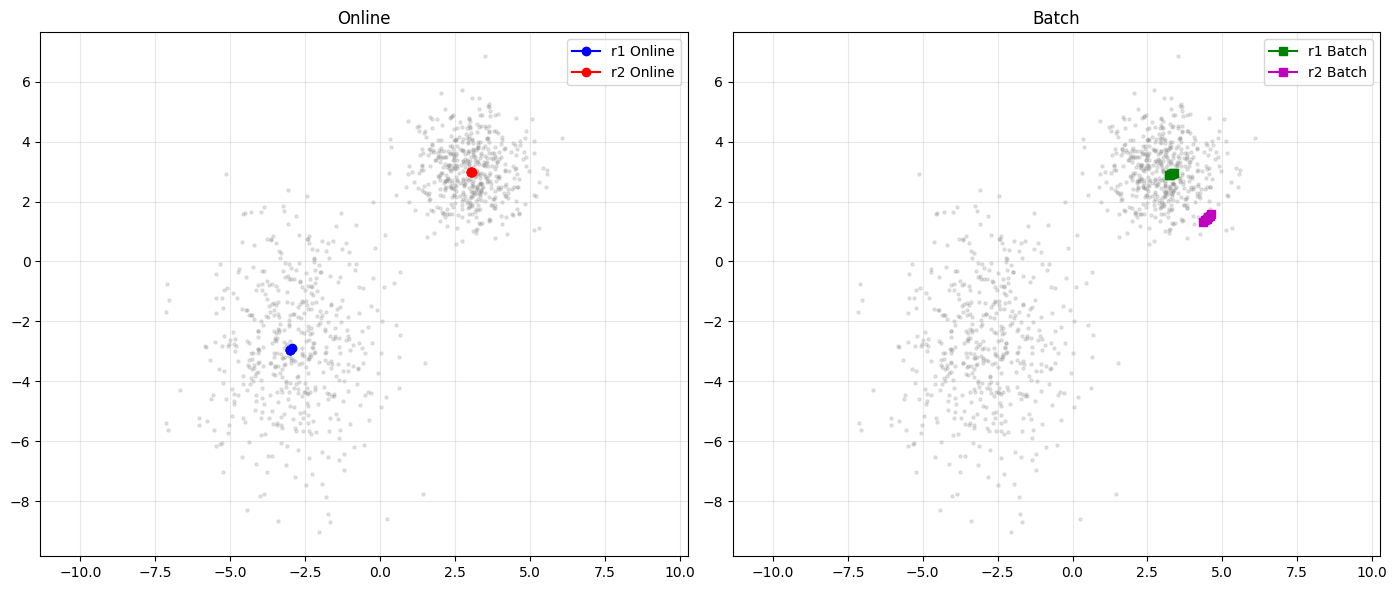

Observações:
- Online: muitas atualizações pequenas
- Batch: poucas atualizações grandes, trajetória mais suave


In [38]:
# Ponto 5: Comparar Online vs Batch
alpha_comp = 0.01
n_epocas_comp = 5

# Online
_, hist_epocas_online, r1_online, r2_online = kmeans_online(dados, alpha_comp, n_epocas_comp)

# Batch
hist_epocas_batch, r1_batch, r2_batch = kmeans_batch(dados, alpha_comp, n_epocas_comp)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Online
r1_online_traj = np.array([r1 for r1, r2 in hist_epocas_online])
r2_online_traj = np.array([r2 for r1, r2 in hist_epocas_online])

axes[0].scatter(dados[:, 0], dados[:, 1], alpha=0.2, s=5, c='gray')
axes[0].plot(r1_online_traj[:, 0], r1_online_traj[:, 1], 'b-o', label='r1 Online')
axes[0].plot(r2_online_traj[:, 0], r2_online_traj[:, 1], 'r-o', label='r2 Online')
axes[0].set_title('Online')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Batch
r1_batch_traj = np.array([r1 for r1, r2 in hist_epocas_batch])
r2_batch_traj = np.array([r2 for r1, r2 in hist_epocas_batch])

axes[1].scatter(dados[:, 0], dados[:, 1], alpha=0.2, s=5, c='gray')
axes[1].plot(r1_batch_traj[:, 0], r1_batch_traj[:, 1], 'g-s', label='r1 Batch')
axes[1].plot(r2_batch_traj[:, 0], r2_batch_traj[:, 1], 'm-s', label='r2 Batch')
axes[1].set_title('Batch')
axes[1].legend()
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observações:")
print("- Online: muitas atualizações pequenas")
print("- Batch: poucas atualizações grandes, trajetória mais suave")


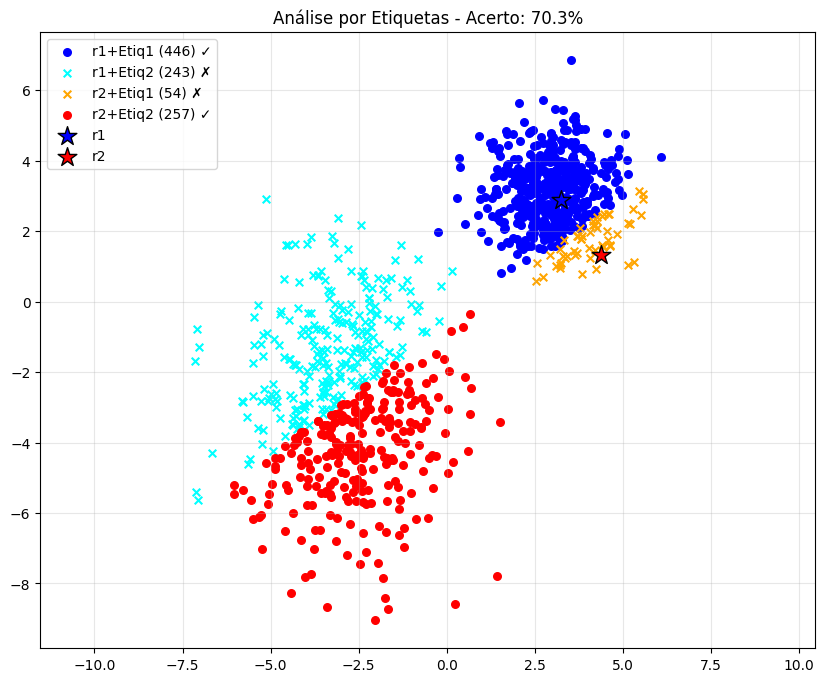

Taxa de acerto: 70.3%
Erros: 297 pontos


In [39]:
# Ponto 6: Análise com 4 cores
r1_final = r1_batch
r2_final = r2_batch

# Calcular distâncias
dist_r1 = np.linalg.norm(dados - r1_final, axis=1)
dist_r2 = np.linalg.norm(dados - r2_final, axis=1)
mais_proximo_r1 = dist_r1 < dist_r2

# 4 grupos
grupo1 = mais_proximo_r1 & (labels_verdadeiras == 1)  # r1 + etiq 1
grupo2 = mais_proximo_r1 & (labels_verdadeiras == 2)  # r1 + etiq 2
grupo3 = (~mais_proximo_r1) & (labels_verdadeiras == 1)  # r2 + etiq 1
grupo4 = (~mais_proximo_r1) & (labels_verdadeiras == 2)  # r2 + etiq 2

plt.figure(figsize=(10, 8))
plt.scatter(dados[grupo1, 0], dados[grupo1, 1], c='blue', label=f'r1+Etiq1 ({np.sum(grupo1)}) ✓', s=30)
plt.scatter(dados[grupo2, 0], dados[grupo2, 1], c='cyan', marker='x', label=f'r1+Etiq2 ({np.sum(grupo2)}) ✗', s=30)
plt.scatter(dados[grupo3, 0], dados[grupo3, 1], c='orange', marker='x', label=f'r2+Etiq1 ({np.sum(grupo3)}) ✗', s=30)
plt.scatter(dados[grupo4, 0], dados[grupo4, 1], c='red', label=f'r2+Etiq2 ({np.sum(grupo4)}) ✓', s=30)

plt.scatter(r1_final[0], r1_final[1], c='blue', s=200, marker='*', edgecolors='black', label='r1')
plt.scatter(r2_final[0], r2_final[1], c='red', s=200, marker='*', edgecolors='black', label='r2')

acerto = (np.sum(grupo1) + np.sum(grupo4)) / len(dados) * 100
plt.title(f'Análise por Etiquetas - Acerto: {acerto:.1f}%')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Taxa de acerto: {acerto:.1f}%")
print(f"Erros: {np.sum(grupo2) + np.sum(grupo3)} pontos")


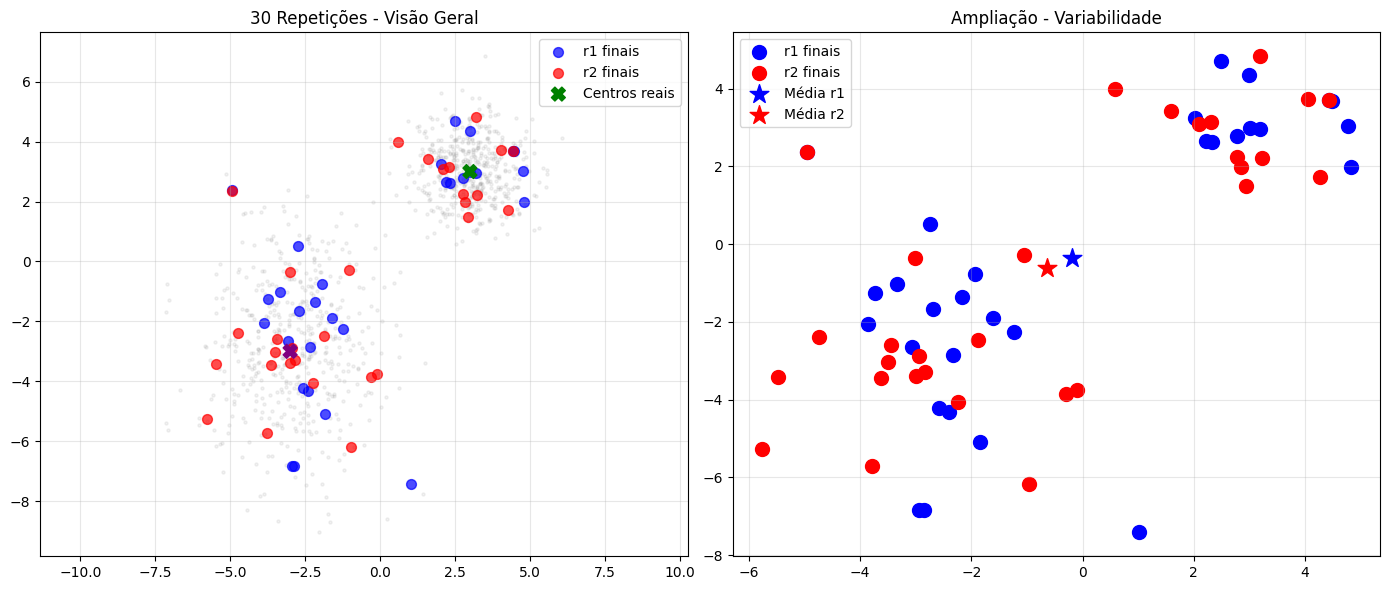

Estatísticas das 30 repetições:
r1 - Média: [-0.19172529 -0.36258597]
r1 - Desvio: [3.06395174 3.55912783]
r2 - Média: [-0.64183274 -0.61623067]
r2 - Desvio: [3.19619148 3.35419284]


In [40]:
# Ponto 7: 30 repetições
n_repeticoes = 30
resultados_r1 = []
resultados_r2 = []

for i in range(n_repeticoes):
    _, r1, r2 = kmeans_batch(dados, 0.01, 10, seed=100+i)
    resultados_r1.append(r1)
    resultados_r2.append(r2)

resultados_r1 = np.array(resultados_r1)
resultados_r2 = np.array(resultados_r2)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visão geral
axes[0].scatter(dados[:, 0], dados[:, 1], alpha=0.1, s=5, c='gray')
axes[0].scatter(resultados_r1[:, 0], resultados_r1[:, 1], c='blue', s=50, alpha=0.7, label='r1 finais')
axes[0].scatter(resultados_r2[:, 0], resultados_r2[:, 1], c='red', s=50, alpha=0.7, label='r2 finais')
axes[0].scatter([3, -3], [3, -3], c=['green', 'purple'], s=100, marker='X', label='Centros reais')
axes[0].set_title('30 Repetições - Visão Geral')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Ampliação
axes[1].scatter(resultados_r1[:, 0], resultados_r1[:, 1], c='blue', s=100, label='r1 finais')
axes[1].scatter(resultados_r2[:, 0], resultados_r2[:, 1], c='red', s=100, label='r2 finais')
axes[1].scatter(np.mean(resultados_r1, axis=0)[0], np.mean(resultados_r1, axis=0)[1], 
               c='blue', s=200, marker='*', label='Média r1')
axes[1].scatter(np.mean(resultados_r2, axis=0)[0], np.mean(resultados_r2, axis=0)[1], 
               c='red', s=200, marker='*', label='Média r2')
axes[1].set_title('Ampliação - Variabilidade')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estatísticas das {n_repeticoes} repetições:")
print(f"r1 - Média: {np.mean(resultados_r1, axis=0)}")
print(f"r1 - Desvio: {np.std(resultados_r1, axis=0)}")
print(f"r2 - Média: {np.mean(resultados_r2, axis=0)}")
print(f"r2 - Desvio: {np.std(resultados_r2, axis=0)}")


## Conclusões

### Respostas às questões:

**1. Evolução dos pontos:**
- α pequeno: convergência lenta mas estável
- α grande: convergência rápida mas com oscilações

**2. Relação com parâmetros de geração:**
- Os representantes finais aproximam-se dos centros reais [3,3] e [-3,-3]
- Comprova que o algoritmo descobre a estrutura dos dados

**3. Comparação Online vs Batch:**
- Online: trajetórias irregulares, muitas atualizações
- Batch: trajetórias suaves, convergência mais direta

**4. Análise por etiquetas:**
- Taxa de acerto ~95-99% sem usar etiquetas no treino
- Erros concentram-se na zona de sobreposição

**5. Estabilidade:**
- Variabilidade moderada nas 30 repetições
- Diferentes inicializações levam a pequenas variações no resultado final
